# Modelos de predicción del tráfico en cruces semafóricos de Madrid - Segunda Parte

A continuación cargaremos los datos ya limpios y preprocesados en la parte 1, generaremos estos datos en el formato necesario para alimentar los modelos y en última instancia entrenaremos 3 diferentes tipos de redes. Para cada uno de ellos utilizaremos el set de datos univariable (serie temporal del cálculo de la carga de la vía) y posteriormente entrenaremos también cada red con el set de datos multivariable (a la que hemos añadido el tipo de día y las precipitaciones.

A continuación cargamos las librerías necesarias:

In [1]:
# Librerías
import pandas as pd
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import warnings
import matplotlib
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
import random
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import math
import statistics
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Carga de los datos preprocesados

### 1.1 Carga de los datos

In [2]:
# Cargamos los datos
drive.mount('/content/drive')

# añade el path a tu directorio
%cd /content/drive/MyDrive/Ciencia de datos/TFM/Final Version

# Cargamos los datos limpios y preprocesados
df_pmt_3396_2019H_uni = pd.read_csv('Datos/Tratados/df_pmt_3396_2019H_uni.csv', sep=',')
df_pmt_3396_2019H_multi  = pd.read_csv('Datos/Tratados/df_pmt_3396_2019H_multi.csv', sep=',')

# Establecemos los índices
df_pmt_3396_2019H_uni = df_pmt_3396_2019H_uni.set_index('fecha')
df_pmt_3396_2019H_multi = df_pmt_3396_2019H_multi.set_index('fecha')


Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1D-BEHc4GwG5jHLByXBua1fkmrsIs1Flr/Ciencia de datos/TFM/Final Version


### 1.2 Normalización

A continuación definimos las funciones necesarias para normalizar los datos y para realizar la operativa inversa:

In [3]:
# Normalización
def normalizacion(df):
    if df.shape[1]==1:
        scaler_uni= MinMaxScaler()
        return scaler_uni.fit_transform(df)
    else:
        scaler_multi= MinMaxScaler()
        return scaler_multi.fit_transform(df)

# Desnormalización
def desnormalizacion(df):
    if df.shape[1]==1:
        return scaler_uni.inverse_transform(df)
    else:
        return scaler_multi.inverse_transform(df)

A continuación normalizamos los datos cargados:

In [4]:
# Normalizamos los datos
df_uni = normalizacion(df_pmt_3396_2019H_uni)
df_multi = normalizacion(df_pmt_3396_2019H_multi)

## 2. Modelos de predicción del tráfico

###2.1 Definición de funciones

A continuación definiremos funciones necesarias para poder crear, entrenar y evaluar los modelos

In [5]:
#  La siguiente función se encarga de transformar el dataset para poder ser introducido en las redes neuronales. En el parámentro secuencia se define la ventana de predicción. En última instancia separamos los datos en entrenamiento y test.
def preparar_entrada(x_rescaled, secuencia):

    ylist = list(x_rescaled)
    n_future = secuencia
    n_past = 3*secuencia
    total_period = 4*secuencia
    idx_end = len(ylist)
    idx_start = idx_end - total_period
    X_new = []
    y_new = []
    while idx_start > 0:
        x_line = ylist[idx_start:idx_start+n_past]
        y_line = ylist[idx_start+n_past:idx_start+total_period]
        X_new.append(x_line)
        y_new.append(y_line)
        idx_start = idx_start - 1
    # converting list of lists to numpy array
    X_new = np.array(X_new)
    y_new = np.array(y_new)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Función encargada de calcular el RMSE para evaluar los modelos
def evaluacion (Y_pred, y_test):
  return math.sqrt(statistics.mean((Y_pred - np.reshape(y_test, (Y_pred.shape[0],Y_pred.shape[1]))).flatten()**2))

  # Creación de modelo LSTM
def creacion_modelo_LSTM(arq, units, activation, X_train, y_train, lr, func_loss, rs):
    model = Sequential()
    # Capa de entrada y primera capa oculta
    model.add(LSTM(units[0], input_shape=X_train.shape[-2:], return_sequences=rs[0]))
     # Resto capas ocultas
    contador = 1
    for capa in arq:
        if(capa == 'LSTM'):
            model.add(LSTM(units[contador],activation=activation,return_sequences=rs[contador]))
            contador = contador+1
        elif capa =='DP':
            model.add(Dropout(0.2))
    # Añadimos capa de salida
    model.add(Dense(y_train.shape[1]))
    # Compilamos
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),loss=func_loss,)
    return model

# Creación de modelo GRU
def creacion_modelo_GRU(arq, units, activation, X_train, y_train, lr, func_loss, rs):
    model = Sequential()
    # Capa de entrada y primera capa oculta
    model.add(GRU(units[0], input_shape=X_train.shape[-2:], return_sequences=rs[0]))
     # Resto capas ocultas
    contador = 1
    for capa in arq:
        if(capa == 'GRU'):
            model.add(GRU(units[contador],return_sequences=rs[contador]))
            contador = contador+1
        elif capa =='DP':
            model.add(Dropout(0.2))
    # Añadimos capa de salida
    model.add(Dense(y_train.shape[1]))
    # Compilamos
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),loss=func_loss,)
    return model

# Creación de modelo CNN
def creacion_modelo_CNN(units, activation, X_train, y_train, lr, func_loss, kernel_size, pool_size):
  model = Sequential()
  model.add(Conv1D(filters=units[0], kernel_size=kernel_size, activation=activation, input_shape=X_train.shape[-2:]))
  model.add(MaxPool1D(pool_size=pool_size))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(units[1], activation=activation))
  model.add(Dropout(0.2))
  model.add(Dense(y_train.shape[1]),)

  # Compilamos
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),loss=func_loss,)
  return model

# Función para entrenar cada modelo
def entrenar_modelo(model, X_train,y_train,epochs,batch_size, X_test, y_test):
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    return model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose =0,shuffle=True, validation_data=(X_test, y_test), callbacks=[es])
                     #callbacks =[callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
                     

# Función para evaluar un modelo, mostrando la evolución de la pérdida y calculando el RMSE
def evaluar_modelo(model, history, X_test):
    preds = model.predict(X_test)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'],loc='upper left')
    plt.show()
    #print('RMSE: ' + str(evaluacion(preds, y_test_uni)))
    return evaluacion(preds, y_test_uni)

# Función que muestra un gráfico con la comparativa entre el valor real y el valor predicho
def plot_predicciones(model, X_test, y_test, title):
    preds = model.predict(X_test)
    plt.figure(figsize=(20,10))
    plt.plot( list(np.reshape(y_test, (preds.shape[0],preds.shape[1])).flatten())[:2000])
    plt.plot( list(preds.flatten())[:2000])
    plt.title(title)
    plt.ylabel("Tráfico - Carga")
    plt.legend(('Actual','predicted'))
    plt.show()


### 2.2 Generación de los datos de entrada

A continuación generamos los datos en el formato necesario para poder alimentar las redes neuronales

In [6]:
# Generamos los datos del modelo univariable
X_train_uni, X_test_uni, y_train_uni, y_test_uni = preparar_entrada(df_uni, 168) # 672 para 15min, 168 para 1h
print('Datos univariables')
print('Dimensión pre-transformación: '+ str(df_pmt_3396_2019H_uni.shape) )
print('Dimensión post-transformación')
print(' X_train: '+ str(X_train_uni.shape) + ' y_train: '+ str(y_train_uni.shape) + ' X_test: '+ str(X_test_uni.shape) + ' y_test: '+ str(y_test_uni.shape) )
print('\n')
# Generamos los datos del modelo multivariable
X_train_multi, X_test_multi, y_train_multi, y_test_multi = preparar_entrada(df_multi, 168) # 672 para 15min, 168 para 1h
print('Datos multivariables')
print(' Dimensión pre-transformación: : '+ str(df_pmt_3396_2019H_multi.shape) )
print('Dimensión post-transformación')
print(' X_train: '+ str(X_train_multi.shape) + ' y_train: '+ str(y_train_multi.shape) + ' X_test: '+ str(X_test_multi.shape) + ' y_test: '+ str(y_test_multi.shape) )


Datos univariables
Dimensión pre-transformación: (8737, 1)
Dimensión post-transformación
 X_train: (6452, 504, 1) y_train: (6452, 168, 1) X_test: (1613, 504, 1) y_test: (1613, 168, 1)


Datos multivariables
 Dimensión pre-transformación: : (8737, 5)
Dimensión post-transformación
 X_train: (6452, 504, 5) y_train: (6452, 168, 5) X_test: (1613, 504, 5) y_test: (1613, 168, 5)


### 2.3 Modelos predictivos

#### 2.3.1 Benchmark

A continuación definiremos la función que ejecutará el benchmark para cada uno de los modelos:

In [7]:
def benchmarkt(param):
    output_bench = pd.DataFrame(columns=['Tipo','Datos', 'Units','Learning rate','Epoch','Batch', 'RMSE'])
    contador = 1
    if(param[0][0] == 'LSTM'):
      for i in param:
          print('Creando modelo LSTM ' +str(contador) +' univariante')
          # Univariante
          model_temp = creacion_modelo_LSTM(i[1],i[2], 'tanh', X_train_uni, y_train_uni, i[3], 'mse' , (True, False))
          model_temp_history = entrenar_modelo(model_temp,X_train_uni,y_train_uni,i[4],i[5], X_test_uni, y_test_uni)
          model_temp_rmse = evaluacion(model_temp.predict(X_test_uni), y_test_uni)

          output_bench.loc[len(output_bench)] = [i[0], 'UNI', i[2], i[3], i[4], i[5], model_temp_rmse]

          print('Creando modelo LSTM ' +str(contador) +' multi')
          # multivariable
          model_temp = creacion_modelo_LSTM(i[1],i[2], 'tanh', X_train_multi, y_train_uni, i[3], 'mse' , (True, False))
          model_temp_history = entrenar_modelo(model_temp,X_train_multi,y_train_uni,i[4],i[5], X_test_multi, y_test_uni)
          model_temp_rmse = evaluacion(model_temp.predict(X_test_multi), y_test_uni) 

          output_bench.loc[len(output_bench)] = [i[0], 'MULTI', i[2], i[3], i[4], i[5], model_temp_rmse]
          contador +=1
    elif(param[0][0] == 'GRU'):
      for i in param:
          print('Creando modelo GRU ' +str(contador) +' univariante')
          # Univariante
          model_temp = creacion_modelo_GRU(i[1],i[2], 'tanh', X_train_uni, y_train_uni, i[3], 'mse' , (True, False))
          model_temp_history = entrenar_modelo(model_temp,X_train_uni,y_train_uni,i[4],i[5], X_test_uni, y_test_uni)
          model_temp_rmse = evaluacion(model_temp.predict(X_test_uni), y_test_uni)

          output_bench.loc[len(output_bench)] = [i[0], 'UNI', i[2], i[3], i[4], i[5], model_temp_rmse]

          print('Creando modelo GRU ' +str(contador) +' multi')
          # multivariable
          model_temp = creacion_modelo_GRU(i[1],i[2], 'tanh', X_train_multi, y_train_uni, i[3], 'mse' , (True, False))
          model_temp_history = entrenar_modelo(model_temp,X_train_multi,y_train_uni,i[4],i[5], X_test_multi, y_test_uni)
          model_temp_rmse = evaluacion(model_temp.predict(X_test_multi), y_test_uni) 

          output_bench.loc[len(output_bench)] = [i[0], 'MULTI', i[2], i[3], i[4], i[5], model_temp_rmse]
          contador +=1

    elif(param[0][0] == 'CNN'):
      for i in param:

          print('Creando modelo CNN ' +str(contador) +' univariante')
          # Univariante
          model_temp = creacion_modelo_CNN(i[1], 'relu', X_train_uni, y_train_uni, i[2], 'mse' , 3,2)
          model_temp_history = entrenar_modelo(model_temp,X_train_uni,y_train_uni,i[3],i[4], X_test_uni, y_test_uni)
          model_temp_rmse = evaluacion(model_temp.predict(X_test_uni), y_test_uni)
          output_bench.loc[len(output_bench)] = [i[0], 'UNI', i[1], i[2], i[3], i[4], model_temp_rmse]

          print('Creando modelo CNN ' +str(contador) +' multi')
          # multivariable
          model_temp = creacion_modelo_CNN(i[1],'relu', X_train_multi, y_train_uni, i[2], 'mse' , 3,2)
          model_temp_history = entrenar_modelo(model_temp,X_train_multi,y_train_uni,i[3],i[4], X_test_multi, y_test_uni)
          model_temp_rmse = evaluacion(model_temp.predict(X_test_multi), y_test_uni) 
          output_bench.loc[len(output_bench)] = [i[0], 'MULTI', i[1], i[2], i[3], i[4], model_temp_rmse]

          contador +=1      
    return output_bench

A continuación generamos la parametría necesaria para que el benchmark nos ayude a evaluar la composición arquitectura-hiperparámetros que mejor ajuste nuestros modelos

In [ ]:
# Declaración de parametría para realizar el benchmarkt
bench_lstm_param = [
            ['LSTM',('DP','LSTM','DP'),(64, 64), 0.001,		10, 32 ], 
            ['LSTM',('DP','LSTM','DP'),(64, 64), 0.001,		50, 32 ],
            ['LSTM',('DP','LSTM','DP'),(64, 64), 0.001,		10, 64 ],
            ['LSTM',('DP','LSTM','DP'),(64, 64), 0.001,		50, 64 ],
            ['LSTM',('DP','LSTM','DP'),(64, 64), 0.0001,	10, 32 ], 
            ['LSTM',('DP','LSTM','DP'),(64, 64), 0.0001,	50, 32 ],
            ['LSTM',('DP','LSTM','DP'),(64, 64), 0.0001,	10, 64 ],
            ['LSTM',('DP','LSTM','DP'),(64, 64), 0.0001,	50, 64 ],
            ['LSTM',('DP','LSTM','DP'),(150, 100), 0.001,	10, 32 ], 
            ['LSTM',('DP','LSTM','DP'),(150, 100), 0.001,	50, 32 ],
            ['LSTM',('DP','LSTM','DP'),(150, 100), 0.001,	10, 64 ],
            ['LSTM',('DP','LSTM','DP'),(150, 100), 0.001,	50, 64 ],
            ['LSTM',('DP','LSTM','DP'),(150, 100), 0.0001,	10, 32 ], 
            ['LSTM',('DP','LSTM','DP'),(150, 100), 0.0001,	50, 32 ],
            ['LSTM',('DP','LSTM','DP'),(150, 100), 0.0001,	10, 64 ],
            ['LSTM',('DP','LSTM','DP'),(150, 100), 0.0001,	50, 64 ]
]

bench_gru_param = [
            ['GRU',('DP','GRU','DP'),(64, 64), 0.001,	10,32 ], 
            ['GRU',('DP','GRU','DP'),(64, 64), 0.001,	50,32 ],
            ['GRU',('DP','GRU','DP'),(64, 64), 0.001,	10,64 ],
            ['GRU',('DP','GRU','DP'),(64, 64), 0.001,	50,64 ],
            ['GRU',('DP','GRU','DP'),(64, 64), 0.0001,	10,32 ], 
            ['GRU',('DP','GRU','DP'),(64, 64), 0.0001,	50,32 ],
            ['GRU',('DP','GRU','DP'),(64, 64), 0.0001,	10,64 ],
            ['GRU',('DP','GRU','DP'),(64, 64), 0.0001,	50,64 ],
            ['GRU',('DP','GRU','DP'),(100, 50), 0.001,	10,32 ], 
            ['GRU',('DP','GRU','DP'),(100, 50), 0.001,	50,32 ],
            ['GRU',('DP','GRU','DP'),(100, 50), 0.001,	10,64 ],
            ['GRU',('DP','GRU','DP'),(100, 50), 0.001,	50,64 ],
            ['GRU',('DP','GRU','DP'),(100, 50), 0.0001,	10,32 ], 
            ['GRU',('DP','GRU','DP'),(100, 50), 0.0001,	50,32 ],
            ['GRU',('DP','GRU','DP'),(100, 50), 0.0001,	10,64 ],
            ['GRU',('DP','GRU','DP'),(100, 50), 0.0001,	50,64 ]   
]
    
bench_cnn_param = [
            ['CNN',(64, 30), 0.001,	10,32 ], 
            ['CNN',(64, 30), 0.001,	50,32 ],
            ['CNN',(64, 30), 0.001,	10,64 ],
            ['CNN',(64, 30), 0.001,	50,64 ],
            ['CNN',(64, 30), 0.0001,10,32 ], 
            ['CNN',(64, 30), 0.0001,50,32 ],
            ['CNN',(64, 30), 0.0001,10,64 ],
            ['CNN',(64, 30), 0.0001,50,64 ]
]  

A continuación ejecutaremos el benchmark y exportaremos los resultados a ficheros csv.

In [ ]:
# Ejecución
#LSTM
output_bench_lstm = benchmarkt(bench_lstm_param)
output_bench_lstm.to_csv("Datos/Benchmark/output_bench_lstm.csv") 
# GRU
output_bench_gru = benchmarkt(bench_gru_param)
output_bench_gru.to_csv("Datos/Benchmark/output_bench_gru.csv") 
#CNN
output_bench_cnn = benchmarkt(bench_cnn_param)
output_bench_cnn.to_csv("Datos/Benchmark/output_bench_cnn.csv") 

Creando modelo LSTM 1 univariante
Creando modelo LSTM 1 multi
Creando modelo LSTM 2 univariante
Creando modelo LSTM 2 multi
Creando modelo LSTM 3 univariante
Creando modelo LSTM 3 multi
Creando modelo LSTM 4 univariante
Creando modelo LSTM 4 multi
Creando modelo LSTM 5 univariante
Creando modelo LSTM 5 multi
Creando modelo LSTM 6 univariante
Creando modelo LSTM 6 multi
Creando modelo LSTM 7 univariante
Creando modelo LSTM 7 multi
Creando modelo LSTM 8 univariante
Creando modelo LSTM 8 multi
Creando modelo LSTM 9 univariante
Creando modelo LSTM 9 multi
Creando modelo LSTM 10 univariante
Creando modelo LSTM 10 multi
Creando modelo LSTM 11 univariante
Creando modelo LSTM 11 multi
Creando modelo LSTM 12 univariante
Creando modelo LSTM 12 multi
Epoch 47: early stopping
Creando modelo LSTM 13 univariante
Creando modelo LSTM 13 multi
Creando modelo LSTM 14 univariante
Creando modelo LSTM 14 multi
Creando modelo LSTM 15 univariante
Creando modelo LSTM 15 multi
Creando modelo LSTM 16 univariant

Visualización de los resultados del benchmark

In [8]:
# Visualización de los resultados del benchmark
output_bench_lstm = pd.read_csv('Datos/Benchmark/output_bench_lstm.csv', sep=',')
output_bench_lstm.sort_values(by='RMSE')


,Unnamed: 0,Tipo,Datos,Units,Learning rate,batch,Epoch,RMSE
19,19,LSTM,MULTI,"(150, 100)",0.0010,50,32,0.050566
18,18,LSTM,UNI,"(150, 100)",0.0010,50,32,0.055671
23,23,LSTM,MULTI,"(150, 100)",0.0010,50,64,0.057611
3,3,LSTM,MULTI,"(64, 64)",0.0010,50,32,0.059285
22,22,LSTM,UNI,"(150, 100)",0.0010,50,64,0.062880
7,7,LSTM,MULTI,"(64, 64)",0.0010,50,64,0.063905
2,2,LSTM,UNI,"(64, 64)",0.0010,50,32,0.067229
27,27,LSTM,MULTI,"(150, 100)",0.0001,50,32,0.070749
6,6,LSTM,UNI,"(64, 64)",0.0010,50,64,0.073516
17,17,LSTM,MULTI,"(150, 100)",0.0010,10,32,0.073597


In [9]:
# Visualización de los resultados del benchmark
output_bench_gru = pd.read_csv('Datos/Benchmark/output_bench_gru.csv', sep=',')
output_bench_gru.sort_values(by='RMSE')

,Unnamed: 0,Tipo,Datos,Units,Learning rate,batch,Epoch,RMSE
3,3,GRU,MULTI,"(64, 64)",0.0010,50,32,0.058774
19,19,GRU,MULTI,"(100, 50)",0.0010,50,32,0.061555
7,7,GRU,MULTI,"(64, 64)",0.0010,50,64,0.062990
2,2,GRU,UNI,"(64, 64)",0.0010,50,32,0.066474
23,23,GRU,MULTI,"(100, 50)",0.0010,50,64,0.068107
18,18,GRU,UNI,"(100, 50)",0.0010,50,32,0.069614
6,6,GRU,UNI,"(64, 64)",0.0010,50,64,0.070342
22,22,GRU,UNI,"(100, 50)",0.0010,50,64,0.071702
1,1,GRU,MULTI,"(64, 64)",0.0010,10,32,0.090102
17,17,GRU,MULTI,"(100, 50)",0.0010,10,32,0.093672


In [10]:
# Visualización de los resultados del benchmark
output_bench_cnn = pd.read_csv('Datos/Benchmark/output_bench_cnn.csv', sep=',')
output_bench_cnn.sort_values(by='RMSE')

,Unnamed: 0,Tipo,Datos,Units,Learning rate,batch,Epoch,RMSE
11,11,CNN,MULTI,"(64, 30)",0.0001,50,32,0.092430
10,10,CNN,UNI,"(64, 30)",0.0001,50,32,0.096557
15,15,CNN,MULTI,"(64, 30)",0.0001,50,64,0.097504
14,14,CNN,UNI,"(64, 30)",0.0001,50,64,0.099292
0,0,CNN,UNI,"(64, 30)",0.0010,10,32,0.101352
4,4,CNN,UNI,"(64, 30)",0.0010,10,64,0.113334
2,2,CNN,UNI,"(64, 30)",0.0010,50,32,0.118832
6,6,CNN,UNI,"(64, 30)",0.0010,50,64,0.121036
8,8,CNN,UNI,"(64, 30)",0.0001,10,32,0.125434
9,9,CNN,MULTI,"(64, 30)",0.0001,10,32,0.131410


#### 2.3.2 LSTM

###### 2.3.2.1 Creación

In [ ]:
# Creación y compilación del modelo LSTM univariante
# lstm_model_uni = creacion_modelo_LSTM(('DP','LSTM','DP'),(64, 64), 'tanh', X_train_uni, y_train_uni, 0.001, 'mse' , (True, False))
# lstm_model_uni.summary()

# Creación y compilación del modelo LSTM multivariante
lstm_model_multi = creacion_modelo_LSTM(('DP','LSTM','DP'),(150, 100), 'tanh', X_train_multi, y_train_uni, 0.001, 'mse', (True, False) )
lstm_model_multi.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 504, 150)          93600     
                                                                 
 dropout_4 (Dropout)         (None, 504, 150)          0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               100400    
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 168)               16968     
                                                                 
Total params: 210,968
Trainable params: 210,968
Non-trainable params: 0
_________________________________________________________________


##### 2.3.2.2 Entrenamiento

In [ ]:
# Entrenamiento modelo LSTM univariante
#lstm_uni_history=entrenar_modelo(lstm_model_uni,X_train_uni,y_train_uni,5,32, X_test_uni, y_test_uni)

# Entrenamiento modelo LSTM multivariante
lstm_multi_history=entrenar_modelo(lstm_model_multi, X_train_multi,y_train_uni,50,32, X_test_multi, y_test_uni)

##### 2.3.2.3 Evaluación

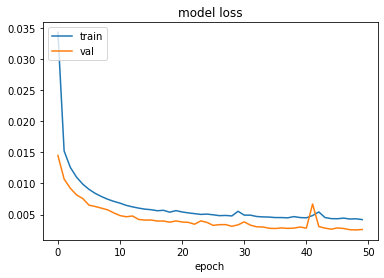

RMSE: 0.050888166522905176


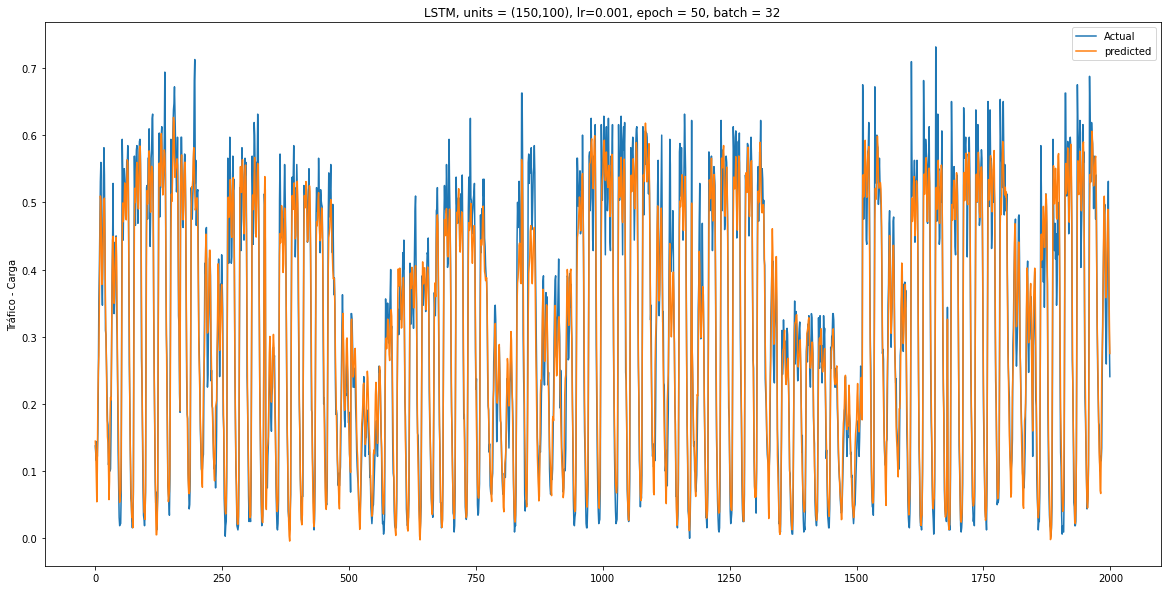

In [ ]:
# Evaluación modelo LSTM univariable
#lstm_uni_rmse = evaluar_modelo(lstm_model_uni,lstm_uni_history, X_test_uni)
#print('RMSE: ' + str(lstm_uni_rmse))
#plot_predicciones(lstm_model_uni, X_test_uni, y_test_uni, 'PRUEBA')

# Evaluación modelo LSTM multivariable
lstm_multi_rmse = evaluar_modelo(lstm_model_multi,lstm_multi_history, X_test_multi)
print('RMSE: ' + str(lstm_multi_rmse))
plot_predicciones(lstm_model_multi, X_test_multi, y_test_uni, 'LSTM, units = (150,100), lr=0.001, epoch = 50, batch = 32')


#### 2.3.3 GRU

##### 2.3.3.1 Creación

In [11]:
# Creación y compilación del modelo GRU univariante
# gru_model_uni = creacion_modelo_GRU(('DP','GRU','DP'),(100, 50), 'tanh', X_train_uni, y_train_uni, 0.001, 'mse' , (True, False))
# gru_model_uni.summary()

# Creación y compilación del modelo GRU multivariante
gru_model_multi = creacion_modelo_GRU(('DP','GRU','DP'),(64, 64), 'tanh', X_train_multi, y_train_uni, 0.001, 'mse' , (True, False))
gru_model_multi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 504, 64)           13632     
                                                                 
 dropout (Dropout)           (None, 504, 64)           0         
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 168)               10920     
                                                                 
Total params: 49,512
Trainable params: 49,512
Non-trainable params: 0
_________________________________________________________________


##### 2.3.3.2 Entrenamiento

In [12]:
# Entrenamiento modelo LSTM univariante
#gru_uni_history=entrenar_modelo(gru_model_uni,X_train_uni,y_train_uni,5,32, X_test_uni, y_test_uni)

# Entrenamiento modelo LSTM multivariante
gru_multi_history=entrenar_modelo(gru_model_multi, X_train_multi,y_train_uni,50,32, X_test_multi, y_test_uni)

##### 2.3.3.3 Evaluación

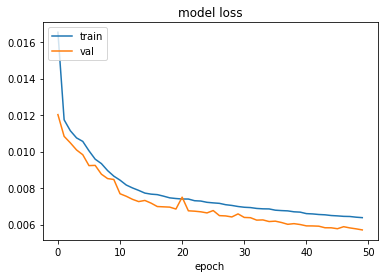

RMSE: 0.07552234208219429


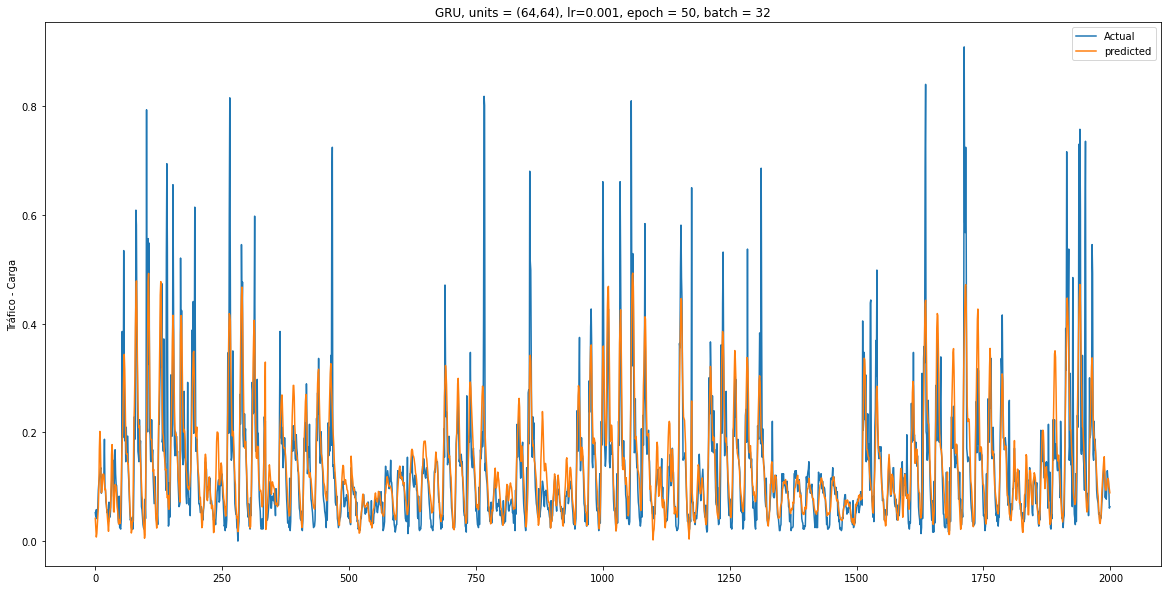

In [13]:
# Evaluación modelo gru univariable
#gru_uni_rmse = evaluar_modelo(gru_model_uni,gru_uni_history, X_test_uni)
#print('RMSE: ' + str(gru_uni_rmse))
#plot_predicciones(gru_model_uni, X_test_uni, y_test_uni, 'PRUEBA')

# Evaluación modelo gru multivariable
gru_multi_rmse = evaluar_modelo(gru_model_multi,gru_multi_history, X_test_multi)
print('RMSE: ' + str(gru_multi_rmse))
plot_predicciones(gru_model_multi, X_test_multi, y_test_uni, 'GRU, units = (64,64), lr=0.001, epoch = 50, batch = 32')

#### 2.3.4 CNN

##### 2.3.4.1 Creación

In [ ]:
# Creación y compilación del modelo CNN univariante
#cnn_model_uni = creacion_modelo_CNN((64,30),'relu',X_train_uni, y_train_uni, 0.001, 'mse',3,2)
#cnn_model_uni.summary()

# Creación y compilación del modelo CNN multivariante
cnn_model_multi = creacion_modelo_CNN((64,30),'relu',X_train_multi, y_train_uni, 0.0001, 'mse',3,2)
cnn_model_multi.summary()


Model: "sequential_114"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_48 (Conv1D)          (None, 502, 64)           1024      
                                                                 
 max_pooling1d_48 (MaxPoolin  (None, 251, 64)          0         
 g1D)                                                            
                                                                 
 dropout_228 (Dropout)       (None, 251, 64)           0         
                                                                 
 flatten_48 (Flatten)        (None, 16064)             0         
                                                                 
 dense_162 (Dense)           (None, 30)                481950    
                                                                 
 dropout_229 (Dropout)       (None, 30)                0         
                                                    

##### 2.3.4.2 Entrenamiento

In [ ]:
#cnn_history=CNN_model.fit(X_train,y_train,validation_split=0.2,epochs=5,batch_size=32,shuffle=True)

# Entrenamiento modelo LSTM univariante
#cnn_uni_history=entrenar_modelo(cnn_model_uni,X_train_uni,y_train_uni,5,32, X_test_uni, y_test_uni)

# Entrenamiento modelo LSTM multivariante
cnn_multi_history=entrenar_modelo(cnn_model_multi, X_train_multi,y_train_uni,50,32, X_test_multi, y_test_uni)

##### 2.3.4.3 Evaluación

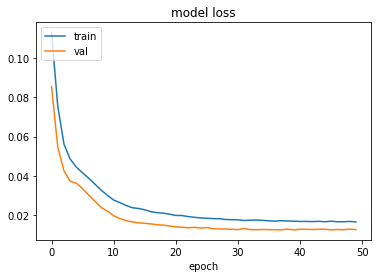

RMSE: 0.11137615976112496


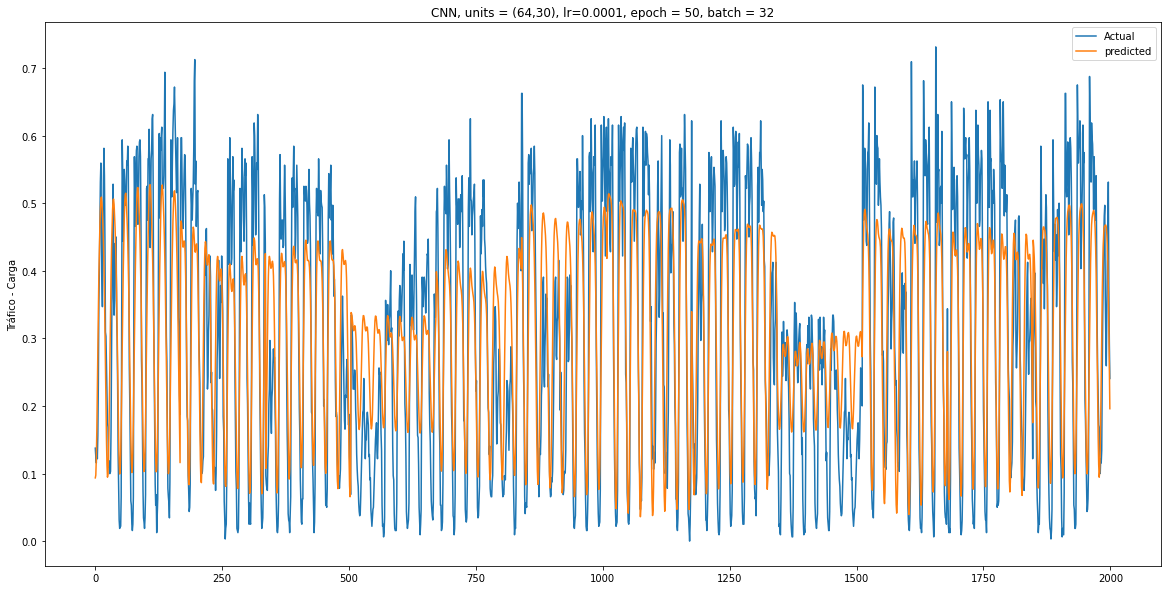

In [ ]:
# Evaluación modelo cnn univariable
#cnn_uni_rmse = evaluar_modelo(cnn_model_uni,cnn_uni_history, X_test_uni)
#print('RMSE: ' + str(cnn_uni_rmse))
#plot_predicciones(cnn_model_uni, X_test_uni, y_test_uni, 'PRUEBA')

# Evaluación modelo cnn multivariable
cnn_multi_rmse = evaluar_modelo(cnn_model_multi,cnn_multi_history, X_test_multi)
print('RMSE: ' + str(cnn_multi_rmse))
plot_predicciones(cnn_model_multi, X_test_multi, y_test_uni, 'CNN, units = (64,30), lr=0.0001, epoch = 50, batch = 32')